In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [6]:
df = pd.read_csv(r'C:\Users\Admin\Desktop\New folder (2)\cutomer_churn_probability\dataset\customer_churn_dataset-testing-master.csv')

In [7]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
num_cols = [i for i in df.columns if df[i].dtypes!='O']
cat_cols = [i for i in df.columns if df[i].dtypes=='O']

for col in df[cat_cols]:
    print(col, df[col].unique())

Gender ['Female' 'Male']
Subscription Type ['Basic' 'Standard' 'Premium']
Contract Length ['Monthly' 'Annual' 'Quarterly']


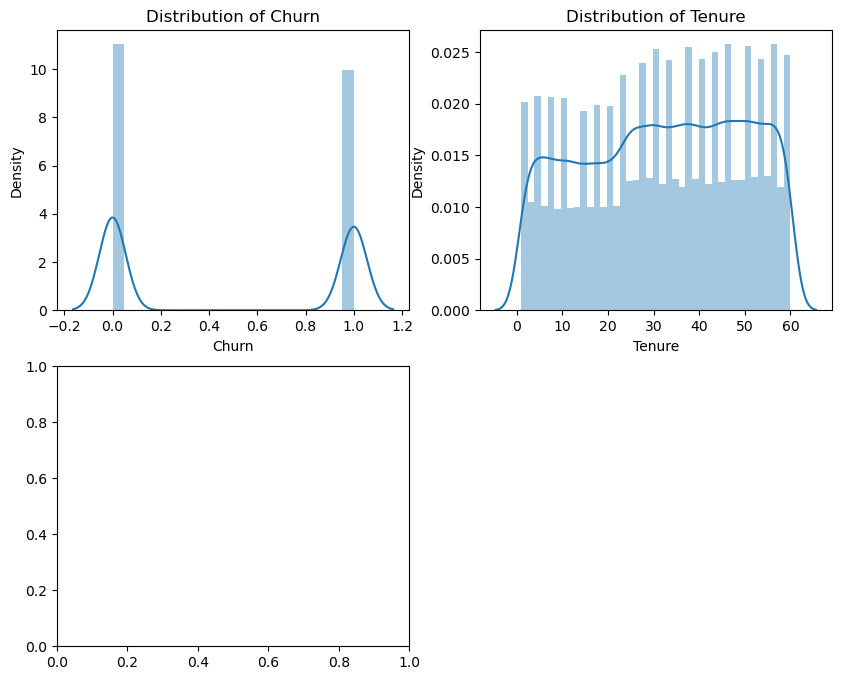

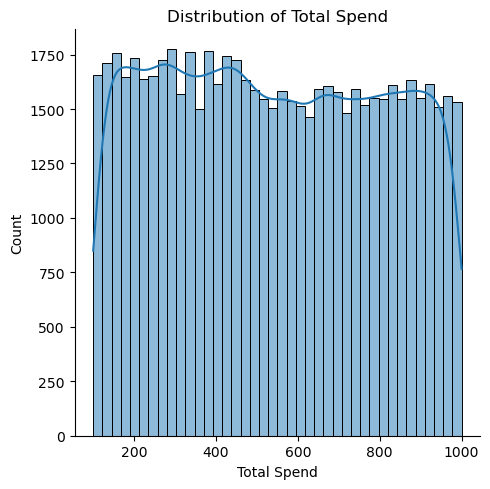

In [10]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.distplot(df['Churn'], kde=True)
plt.title('Distribution of Churn')

plt.subplot(2,2,2)
sns.distplot(df['Tenure'], kde=True)
plt.title('Distribution of Tenure')

plt.subplot(2,2,3)
sns.displot(df['Total Spend'], kde=True)
plt.title('Distribution of Total Spend')

plt.tight_layout()
plt.show()


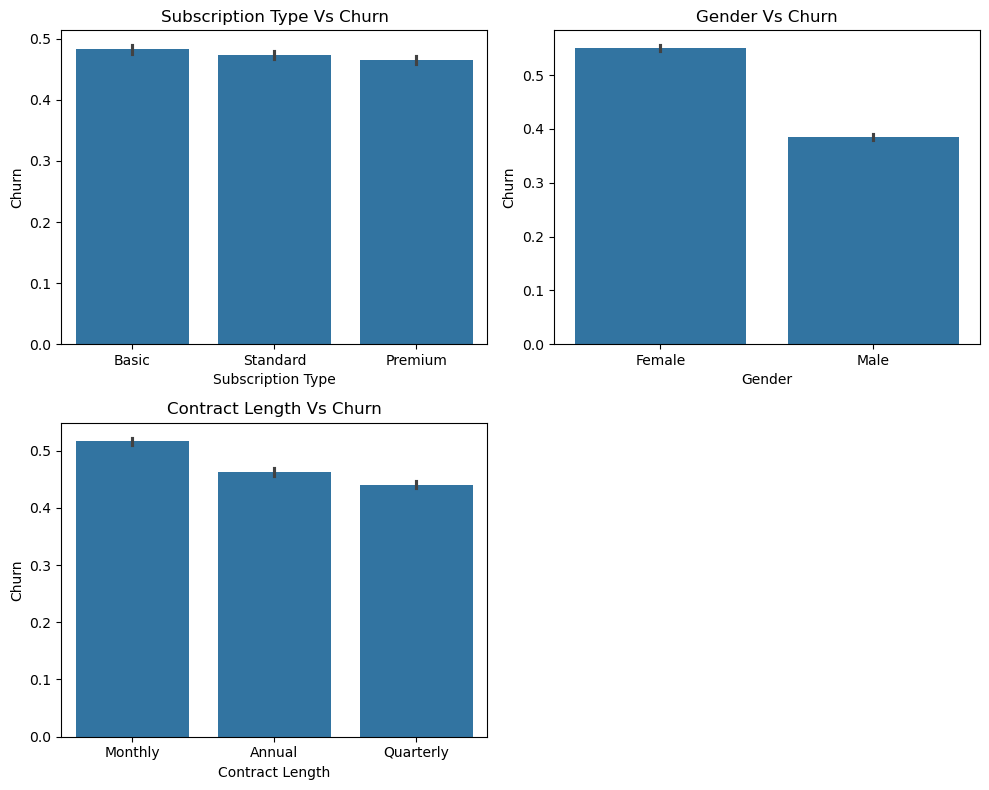

In [11]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
sns.barplot(x = 'Subscription Type', y='Churn', data=df)
plt.title('Subscription Type Vs Churn')

plt.subplot(2,2,2)
sns.barplot(x = 'Gender', y='Churn', data=df)
plt.title('Gender Vs Churn')

plt.subplot(2,2,3)
sns.barplot(x = 'Contract Length', y='Churn', data=df)
plt.title('Contract Length Vs Churn')

plt.tight_layout()
plt.show()

In [12]:
li = []

for val in df['Contract Length']:
    if val=='Monthly':
        li.append(1)
    elif val=='Quarterly':
        li.append(3)
    else:
        li.append(12)


df['Contract_month'] = li

In [13]:
df['Avg_monthly_spend'] = round(df['Total Spend']/df['Contract_month'],2)

In [14]:
df.drop(['CustomerID','Contract Length'], axis=1, inplace=True)

In [15]:
df['Tenure Bucket'] = pd.cut(df['Tenure'], bins=[-1, 6,12, float('inf')],
labels=['Short', 'Medium','Long'])

In [16]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()

In [17]:
df['Gender'] = df['Gender'].map({'Female':0, 'Male':1})
df['Subscription Type'] = df['Subscription Type'].map({'Basic':0, 'Standard':1, 'Premium':2})
df['Tenure Bucket'] = df['Tenure Bucket'].map({'Short':0, 'Medium':1, 'Long':2})

In [18]:
df['Tenure Bucket'] = df['Tenure Bucket'].astype(int)

<Axes: >

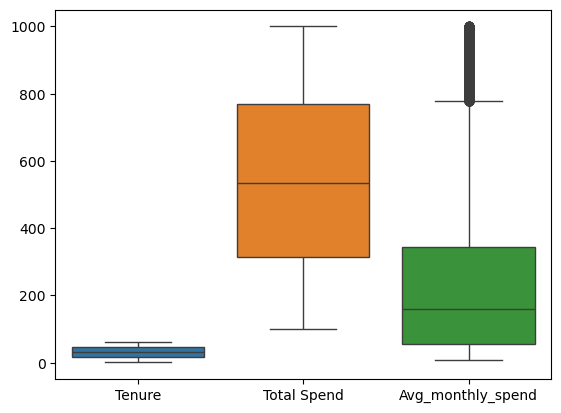

In [19]:
cols = ['Tenure','Total Spend', 'Avg_monthly_spend']

sns.boxplot(df[cols])

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = ['Churn','Age', 'Tenure', 'Usage Frequency','Support Calls','Payment Delay','Avg_monthly_spend','Total Spend','Contract_month','Last Interaction']


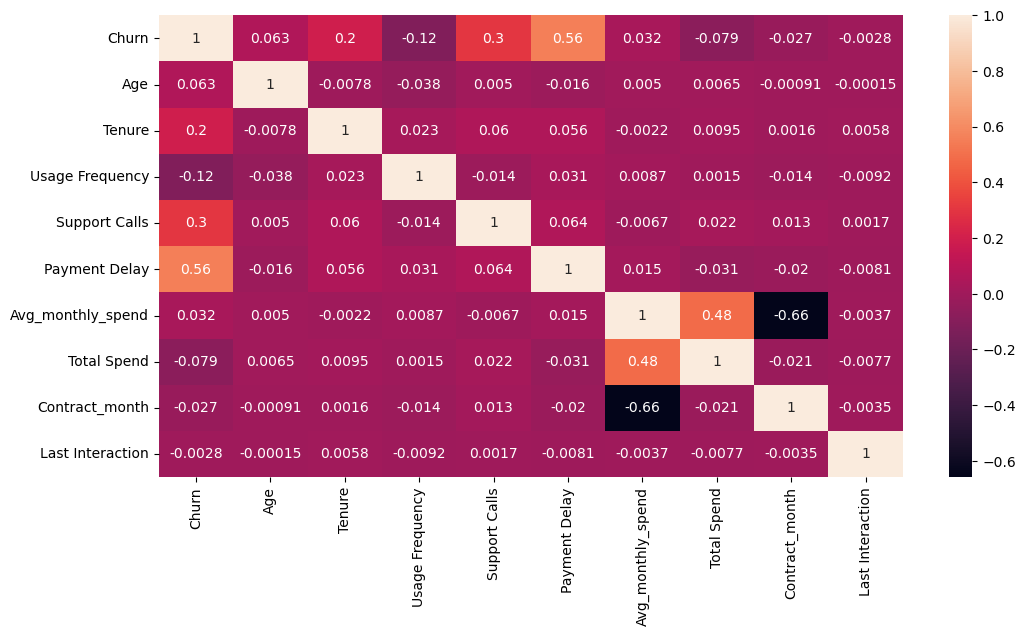

In [21]:
corr = df[cols].corr()

plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)
plt.show()

In [22]:
x = df.drop('Churn', axis=1)
y = df['Churn']

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = ['Age', 'Tenure', 'Usage Frequency','Support Calls','Payment Delay','Avg_monthly_spend','Total Spend','Contract_month','Last Interaction']


In [25]:
x_train[cols] = scaler.fit_transform(x_train[cols])

In [26]:
x_test[cols] = scaler.transform(x_test[cols])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

In [28]:
models = {
    'lr' : LogisticRegression(),
    'dt' : DecisionTreeClassifier(),
    'rfe' : RandomForestClassifier(),
}

In [29]:
def train(models,x_train, x_test, y_train, y_test):
  score = []
  for name, model in models.items():
    print(f'training {name}......')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc_score = accuracy_score(y_test, y_pred)

    score.append({'Models':name, 'Acc_score':acc_score})
    
  return score


In [30]:
train(models, x_train, x_test, y_train, y_test)

training lr......
training dt......
training rfe......


[{'Models': 'lr', 'Acc_score': 0.8299590949101642},
 {'Models': 'dt', 'Acc_score': 0.9983948635634029},
 {'Models': 'rfe', 'Acc_score': 0.9992233210790659}]

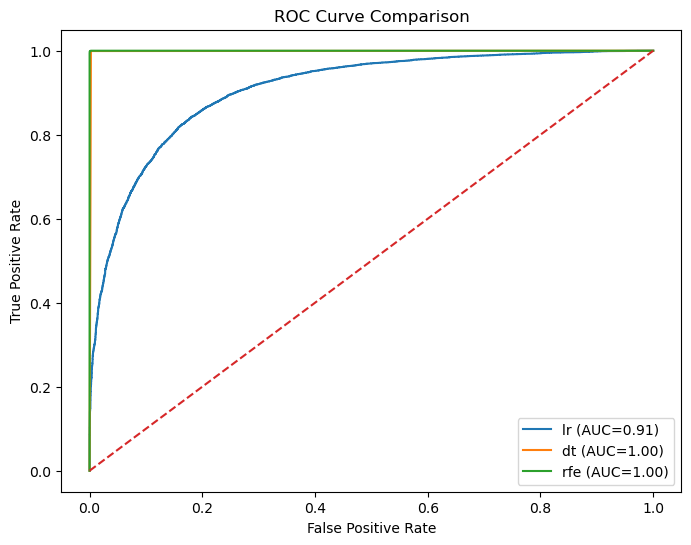

In [31]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [32]:
Dt = DecisionTreeClassifier(criterion="gini",        # or "entropy"
    max_depth=6,             # limits overfitting
    min_samples_split=20,    # minimum samples to split a node
    min_samples_leaf=10,     # minimum samples at leaf node
    max_features="sqrt",     # feature randomness
    class_weight="balanced", # handles churn imbalance
    random_state=42)

rfe = RandomForestClassifier(n_estimators=100,        # number of trees
    max_depth=8,
    min_samples_split=30,
    min_samples_leaf=10,
    max_features="sqrt",
    bootstrap=True,
    class_weight="balanced",
    n_jobs=-1,
    random_state=42)

In [33]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# Random Forest CV AUC
rf_cv_auc = cross_val_score(
    rfe,          # your tuned RF
    x, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)
print("Random Forest CV AUC scores:", rf_cv_auc)
print("RF Mean CV AUC:", rf_cv_auc.mean())


Random Forest CV AUC scores: [0.99998534 0.99998088 0.999985   0.99997728 0.99998947]
RF Mean CV AUC: 0.9999835937707665


In [34]:
rfe.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=10, min_samples_split=30, n_jobs=-1,
                       random_state=42)

In [35]:
y_pred = rfe.predict(x_test)

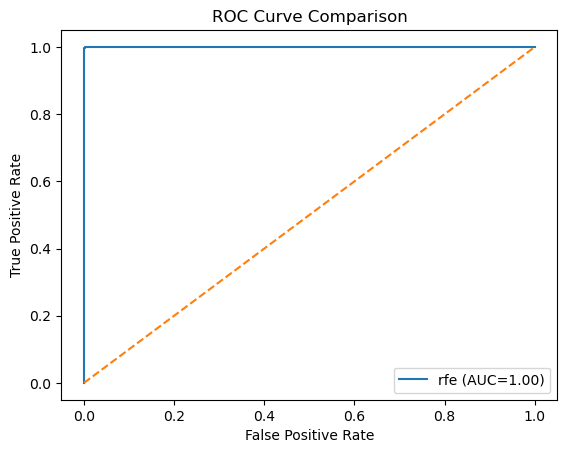

In [36]:
y_prob = rfe.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [37]:
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.997411070263553
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10134
           1       1.00      1.00      1.00      9179

    accuracy                           1.00     19313
   macro avg       1.00      1.00      1.00     19313
weighted avg       1.00      1.00      1.00     19313



In [38]:
x_train

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Total Spend,Last Interaction,Contract_month,Avg_monthly_spend,Tenure Bucket
5871,0.863771,0,-1.456615,1.577671,-1.735191,1.111588,2,0.103525,0.058326,1.387486,-0.797673,1
40570,1.365366,0,0.998131,-0.576364,1.480285,-1.936825,2,-1.497003,0.637668,1.387486,-0.926676,2
200,-0.426046,1,-0.463027,1.577671,-1.413643,0.998684,2,0.095848,-0.868620,-0.899968,1.127796,2
64037,1.222053,0,-0.287688,-0.349624,1.158737,0.772875,0,-1.090154,-0.752752,-0.899968,-0.019311,2
13249,-0.855985,0,-0.813705,-0.803105,-1.735191,0.772875,2,1.750111,0.174195,-0.899968,2.727806,2
...,...,...,...,...,...,...,...,...,...,...,...,...
62570,0.577145,1,0.355222,-0.462994,-0.127453,1.224492,2,0.103525,-1.216225,-0.484067,-0.270523,2
38158,0.792114,1,0.705899,1.691042,-0.770548,-1.598113,2,-0.360897,0.637668,-0.899968,0.686030,2
860,-0.641016,0,0.881238,-0.689735,-1.092096,0.998684,1,-0.334029,-1.100357,-0.484067,-0.411591,2
15795,-1.285924,1,1.465702,0.443968,1.480285,-0.920687,2,1.562039,1.332878,1.387486,-0.680103,2


In [40]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(rfe, f)

In [41]:
with open('scaler.pkl','wb') as f:
    pickle.dump(scaler, f)